In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import bayesian_pdes as bpdes
from bayesian_pdes.problems import laplacian_natural_kernel, laplacian_integral_kernel, laplacian_inverse_problem
import sympy as sp
import os
import pickle
import mcmc
#import gpanim
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [5]:
n_pts = 39 # for figures in paper
#n_pts = 9 # for gp anim

In [4]:
epsilon = 2.5
nat_op_cache = laplacian_natural_kernel.LaplacianNaturalKernel(epsilon)
int_op_cache = laplacian_integral_kernel.LaplacianIntegralKernel(epsilon)

In [6]:
def rhs(x):
    return np.sin(2*np.pi*x)

design_points = np.linspace(0,1,n_pts+2)[1:-1, None]
g = rhs(design_points)

In [7]:
bdy = np.array([[0.], [1.]])
bdy_obs = np.zeros_like(bdy)

In [8]:
posterior = bpdes.collocate(nat_op_cache.operators, nat_op_cache.operators_bar, [(design_points, g)], nat_op_cache)

In [9]:
int_posterior = bpdes.collocate(
    int_op_cache.operators, 
    int_op_cache.operators_bar, 
    [(design_points, g), (bdy, bdy_obs)], 
    int_op_cache)

In [10]:
test_points = np.linspace(0,1,101)[:,None]

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


(0, 1)

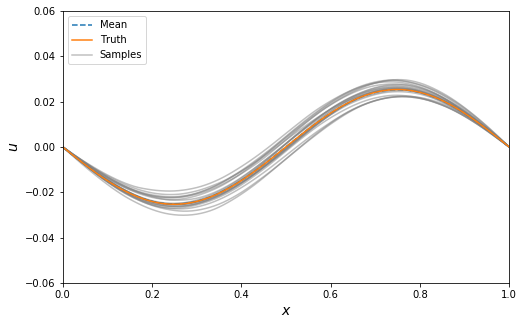

In [13]:
mu, cov = posterior(test_points)
plt.figure(figsize=(8,5))
h_samples = plt.plot(test_points, np.random.multivariate_normal(mu.ravel(), cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(test_points, mu, linestyle='--', label='Mean Function')
#plt.plot(test_points, mu_new)
h_truth = plt.plot(test_points, -np.sin(2*np.pi*test_points)/(4*np.pi**2), label='Truth')
plt.ylim(-0.06, 0.06)
plt.legend((h_mean[0], h_truth[0], h_samples[0]), ('Mean', 'Truth', 'Samples'), loc=2)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
plt.savefig('figures/example_mean_samples.pdf', transparent=True, bbox_inches=0)
plt.xlim(0,1)

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in sqrt


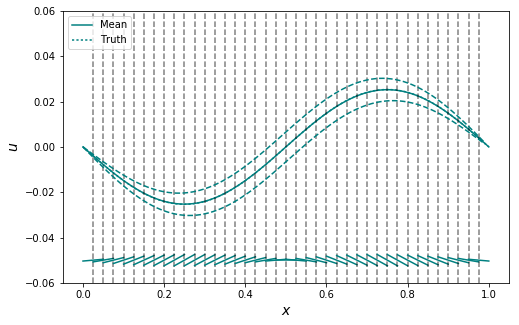

In [14]:
color='teal'
plt.figure(figsize=(8,5))
h_mean = plt.plot(test_points, mu, label='Mean', color=color)
#plt.plot(test_points, mu_new)
h_truth = plt.plot(test_points, -np.sin(2*np.pi*test_points)/(4*np.pi**2), label='Truth', linestyle='dotted', color=color)
plt.ylim(-0.06, 0.06)
plt.legend((h_mean[0], h_truth[0]), ('Mean', 'Truth', 'Samples'), loc=2)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u$', fontsize=14)

x_size = 0.025
y_pos = -0.05
for p, gval in zip(design_points, g):
    p = np.asscalar(p)
    gval = np.asscalar(gval)
    plt.axvline(p, linestyle='--', c='black', alpha=0.5)
    dx = x_size*2
    x = [p-x_size, p+x_size]
    y = [y_pos - gval*dx**2, y_pos + gval*dx**2]
    plt.plot(x, y, c=color)

cov_shift = np.sqrt(np.diag(cov))
cov_max = 2.0

plt.plot(test_points.ravel(), mu.ravel()-cov_max*cov_shift, linestyle='--', c=color)
plt.plot(test_points.ravel(), mu.ravel()+cov_max*cov_shift, linestyle='--', c=color)

#n = 50
#for scale in np.linspace(0, cov_max, n)[1:]:
#    a = 1-scale / cov_max
#    plt.fill_between(test_points.ravel(), mu.ravel()-scale*cov_shift, mu.ravel()+scale*cov_shift, 
#                     color=color, 
#                     alpha=0.5*1./n)

#a = gpanim.animate_gp(test_points, mu, cov, samples=10, plot_kwargs={
#        'linestyle': '--',
#        'c': 'gray'
#    })
#a.save('/Users/benorn/Downloads/natural_vid.mp4', extra_args=['-vcodec', 'libx264'])
#gpanim.utils.to_tex(a, 'frames', ext='.pdf')

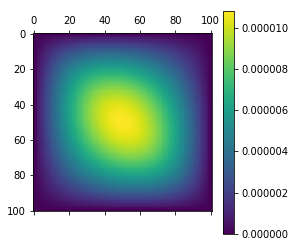

In [15]:
plt.matshow(cov); plt.colorbar();

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


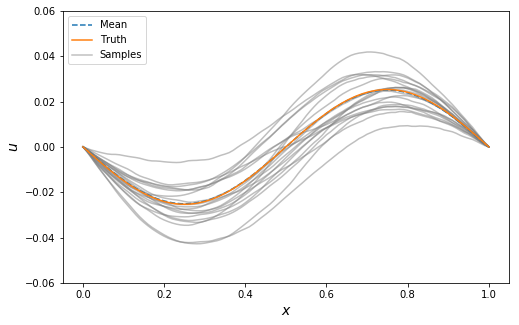

In [16]:
mu_int, cov_int = int_posterior(test_points)
plt.figure(figsize=(8,5))
h_samples = plt.plot(test_points, np.random.multivariate_normal(mu_int.ravel(), cov_int, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(test_points, mu_int, linestyle='--', label='Mean Function')
#plt.plot(test_points, mu_new)
h_truth = plt.plot(test_points, -np.sin(2*np.pi*test_points)/(4*np.pi**2), label='Truth')
plt.ylim(-0.06, 0.06)
plt.legend((h_mean[0], h_truth[0], h_samples[0]), ('Mean', 'Truth', 'Samples'), loc=2)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
plt.savefig('figures/example_mean_samples_integral.pdf', transparent=True, bbox_inches=0)

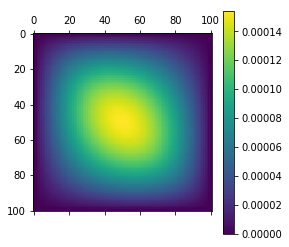

In [17]:
plt.matshow(cov_int); plt.colorbar()

In [23]:
nat_dest = 'kernel_results/natural_eps={}.pkl'.format(epsilon)
int_dest = 'kernel_results/integral_eps={}.pkl'.format(epsilon)
if os.path.exists(nat_dest) and os.path.exists(int_dest):
    with open(nat_dest, 'rb') as f:
        nat_results = pickle.load(f)
    with open(int_dest, 'rb') as f:
        int_results = pickle.load(f)
    ns = sorted(int_results.keys())
else:
    nat_results = {}
    int_results = {}
    ns = 5*np.arange(1,20)
    for n_pts in 5*np.arange(1,20):
        print n_pts
        design_points = np.linspace(0,1,n_pts+1)[1:-1, None]
        g = rhs(design_points)
        nat_posterior = bpdes.collocate(
            nat_op_cache.operators, 
            nat_op_cache.operators_bar, 
            [(design_points, g)], 
            op_system=nat_op_cache)
        int_posterior = bpdes.collocate(
            int_op_cache.operators, 
            int_op_cache.operators_bar, 
            [(design_points, g), (bdy, bdy_obs)], 
            op_system=int_op_cache)
        nat_results[n_pts] = nat_posterior(test_points)
        int_results[n_pts] = int_posterior(test_points)
    with open(nat_dest, 'wb') as f:
        pickle.dump(nat_results, f)
    with open(int_dest, 'wb') as f:
        pickle.dump(int_results, f)

In [24]:
int_errors = np.empty_like(ns, dtype=np.float)
int_traces = np.empty_like(ns, dtype=np.float)
nat_errors = np.empty_like(ns, dtype=np.float)
nat_traces = np.empty_like(ns, dtype=np.float)
actual = -np.sin(2*np.pi*test_points)/(4*np.pi**2)
for ix, n in enumerate(ns):
    mu_int, cov_int = int_results[n]
    mu_nat, cov_nat = nat_results[n]
    
    int_errors[ix] = np.linalg.norm(mu_int - actual)
    nat_errors[ix] = np.linalg.norm(mu_nat - actual)
    
    int_traces[ix] = np.trace(cov_int)
    nat_traces[ix] = np.trace(cov_nat)

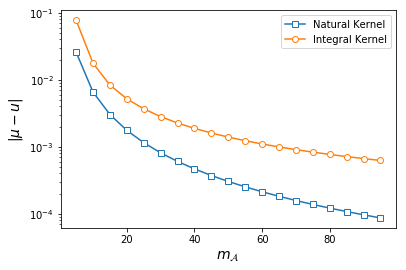

In [25]:
plt.semilogy(ns, nat_errors, label='Natural Kernel', marker='s', markerfacecolor='white')
plt.ylabel('$\|\\mu - u \|$', fontsize=14)
plt.xlabel('$m_{\\mathcal{A}}$', fontsize=14)
plt.savefig('figures/kernel_mean_error_nat.pdf', transparent=True, bbox_inches=0)
plt.semilogy(ns, int_errors, label='Integral Kernel', marker='o', markerfacecolor='white')
plt.legend()
plt.savefig('figures/kernel_mean_error.pdf', transparent=True, bbox_inches=0)

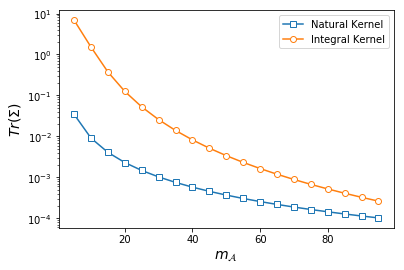

In [26]:
plt.semilogy(ns, nat_traces, label='Natural Kernel', marker='s', markerfacecolor='white')
plt.ylabel('$Tr(\\Sigma)$', fontsize=14)
plt.xlabel('$m_{\\mathcal{A}}$', fontsize=14)
plt.savefig('figures/kernel_trace_nat.pdf', transparent=True, bbox_inches=0)
plt.semilogy(ns, int_traces, label='Integral Kernel', marker='o', markerfacecolor='white')
plt.legend()
plt.savefig('figures/kernel_trace.pdf', transparent=True, bbox_inches=0)

# Inverse Problem

In [27]:
np.random.seed(12345)
noise_variance = 0.001
true_locations = np.array([[0.25], [0.75]])
true_obs = -np.sin(2*np.pi*true_locations) / (4*np.pi**2) + np.random.normal(0, noise_variance, true_locations.shape)

In [28]:
def sample_forward(delta, design_points, sys_factory, locations):
    op_system = sys_factory.get_operator_system(delta)
    
    obs = [(design_points, rhs(design_points))]
    if len(op_system.operators) > 1:
        obs += [(np.array([[0.], [1.]]), np.array([[0.], [0.]]))]
    
    posterior = bpdes.collocate(op_system.operators, op_system.operators_bar, obs, op_system)
    return posterior(locations)

In [41]:
def likelihood(delta, design_points, sys_factory, bayesian=True, diag=False, debug=False):
    mu, Sigma = sample_forward(np.exp(delta), design_points, sys_factory, true_locations)
    error_mat = noise_variance**2*np.eye(Sigma.shape[0])
    if debug:
        print('Sigma trace: {} Standard trace: {}'.format(np.trace(Sigma), np.trace(error_mat)))
    cov = error_mat
    if bayesian:
        cov += Sigma
    if diag:
        cov += np.diag(np.diag(Sigma))
    return stats.multivariate_normal.logpdf(true_obs.ravel(), mu.ravel(), cov)

In [42]:
int_results_bayes = {}
int_results_non_bayes = {}
int_results_trace = {}
nat_results_bayes = {}
nat_results_non_bayes = {}
nat_results_trace = {}

In [43]:
def log_prior(delta):
    return stats.norm.logpdf(np.exp(delta))

In [55]:
from mcmc import progress
from mcmc.rwm import AdaptiveProposal
n_iter = 20000
p = progress.stdout_progress.PrintProgress(5000)
ns = np.array([4, 8, 16, 32, 64])
init_propose_sigma = 1.0
for n_pts in ns:
    print n_pts
    design_points = np.linspace(0,1,n_pts+1)[1:-1, None]
    int_factory = laplacian_inverse_problem.LaplacianInverseProblemFactory(int_op_cache)
    nat_factory = laplacian_inverse_problem.LaplacianInverseProblemFactory(nat_op_cache, natural_kernel=True)
    
    def nat_likelihood(x):
        return likelihood(x, design_points, nat_factory)
    def int_likelihood(x):
        return likelihood(x, design_points, int_factory)
    def nat_likelihood_non_bayes(x):
        return likelihood(x, design_points, nat_factory, False)
    def int_likelihood_non_bayes(x):
        return likelihood(x, design_points, int_factory, False)
    def nat_likelihood_diag(x):
        return likelihood(x, design_points, nat_factory, False, True)
    def int_likelihood_diag(x):
        return likelihood(x, design_points, int_factory, False, True)
    
    proposal = AdaptiveProposal(init_propose_sigma)
    print('Integral (Bayesian)')
    int_samples = mcmc.rwm(n_iter, proposal, int_likelihood, log_prior, 0.0, p)
    int_results_bayes[n_pts] = int_samples
    
    print('Integral (Collocation)')
    int_samples = mcmc.rwm(n_iter, proposal, int_likelihood_non_bayes, log_prior, 0.0, p)
    int_results_non_bayes[n_pts] = int_samples
    
    print('Integral (Diag)')
    int_samples = mcmc.rwm(n_iter, proposal, int_likelihood_diag, log_prior, 0.0, p)
    int_results_trace[n_pts] = int_samples
    
    print('Natural (Bayesian)')
    nat_samples = mcmc.rwm(n_iter, proposal, nat_likelihood, log_prior, 0.0, p)
    nat_results_bayes[n_pts] = nat_samples
    
    print('Natural (Collocation)')
    nat_samples = mcmc.rwm(n_iter, proposal, nat_likelihood_non_bayes, log_prior, 0.0, p)
    nat_results_non_bayes[n_pts] = nat_samples
    
    print('Natural (Diag)')
    nat_samples = mcmc.rwm(n_iter, proposal, nat_likelihood_diag, log_prior, 0.0, p)
    nat_results_trace[n_pts] = nat_samples
    
    init_propose_sigma = proposal.variance
    

4
Integral (Bayesian)
Iter 5000: Accept (33% 33%) T/Iter 0.0011s Remaining 17s
Iter 10000: Accept (34% 34%) T/Iter 0.0011s Remaining 10s
Iter 15000: Accept (34% 34%) T/Iter 0.0013s Remaining 6s
Iter 20000: Accept (34% 34%) T/Iter 0.0012s Remaining 0s
Integral (Collocation)
Iter 5000: Accept (28% 28%) T/Iter 0.0012s Remaining 17s
Iter 10000: Accept (31% 29%) T/Iter 0.0011s Remaining 11s
Iter 15000: Accept (28% 29%) T/Iter 0.0010s Remaining 5s
Iter 20000: Accept (34% 30%) T/Iter 0.0011s Remaining 0s
Integral (Diag)
Iter 5000: Accept (38% 38%) T/Iter 0.0010s Remaining 15s
Iter 10000: Accept (34% 36%) T/Iter 0.0010s Remaining 10s
Iter 15000: Accept (34% 35%) T/Iter 0.0010s Remaining 5s
Iter 20000: Accept (33% 35%) T/Iter 0.0010s Remaining 0s
Natural (Bayesian)
Iter 5000: Accept (35% 35%) T/Iter 0.0007s Remaining 10s
Iter 10000: Accept (36% 36%) T/Iter 0.0007s Remaining 6s
Iter 15000: Accept (35% 35%) T/Iter 0.0008s Remaining 4s
Iter 20000: Accept (36% 36%) T/Iter 0.0008s Remaining 0s
Natur

In [51]:
labels = ['Natural (Probabilistic)', 'Natural (Standard)', 'Natural (Diagonal)', 'Integral (Probabilistic)', 'Integral (Standard)', 'Integral (Diagonal)']
dictionaries = [nat_results_bayes, nat_results_non_bayes, nat_results_trace, int_results_bayes, int_results_non_bayes, int_results_trace]

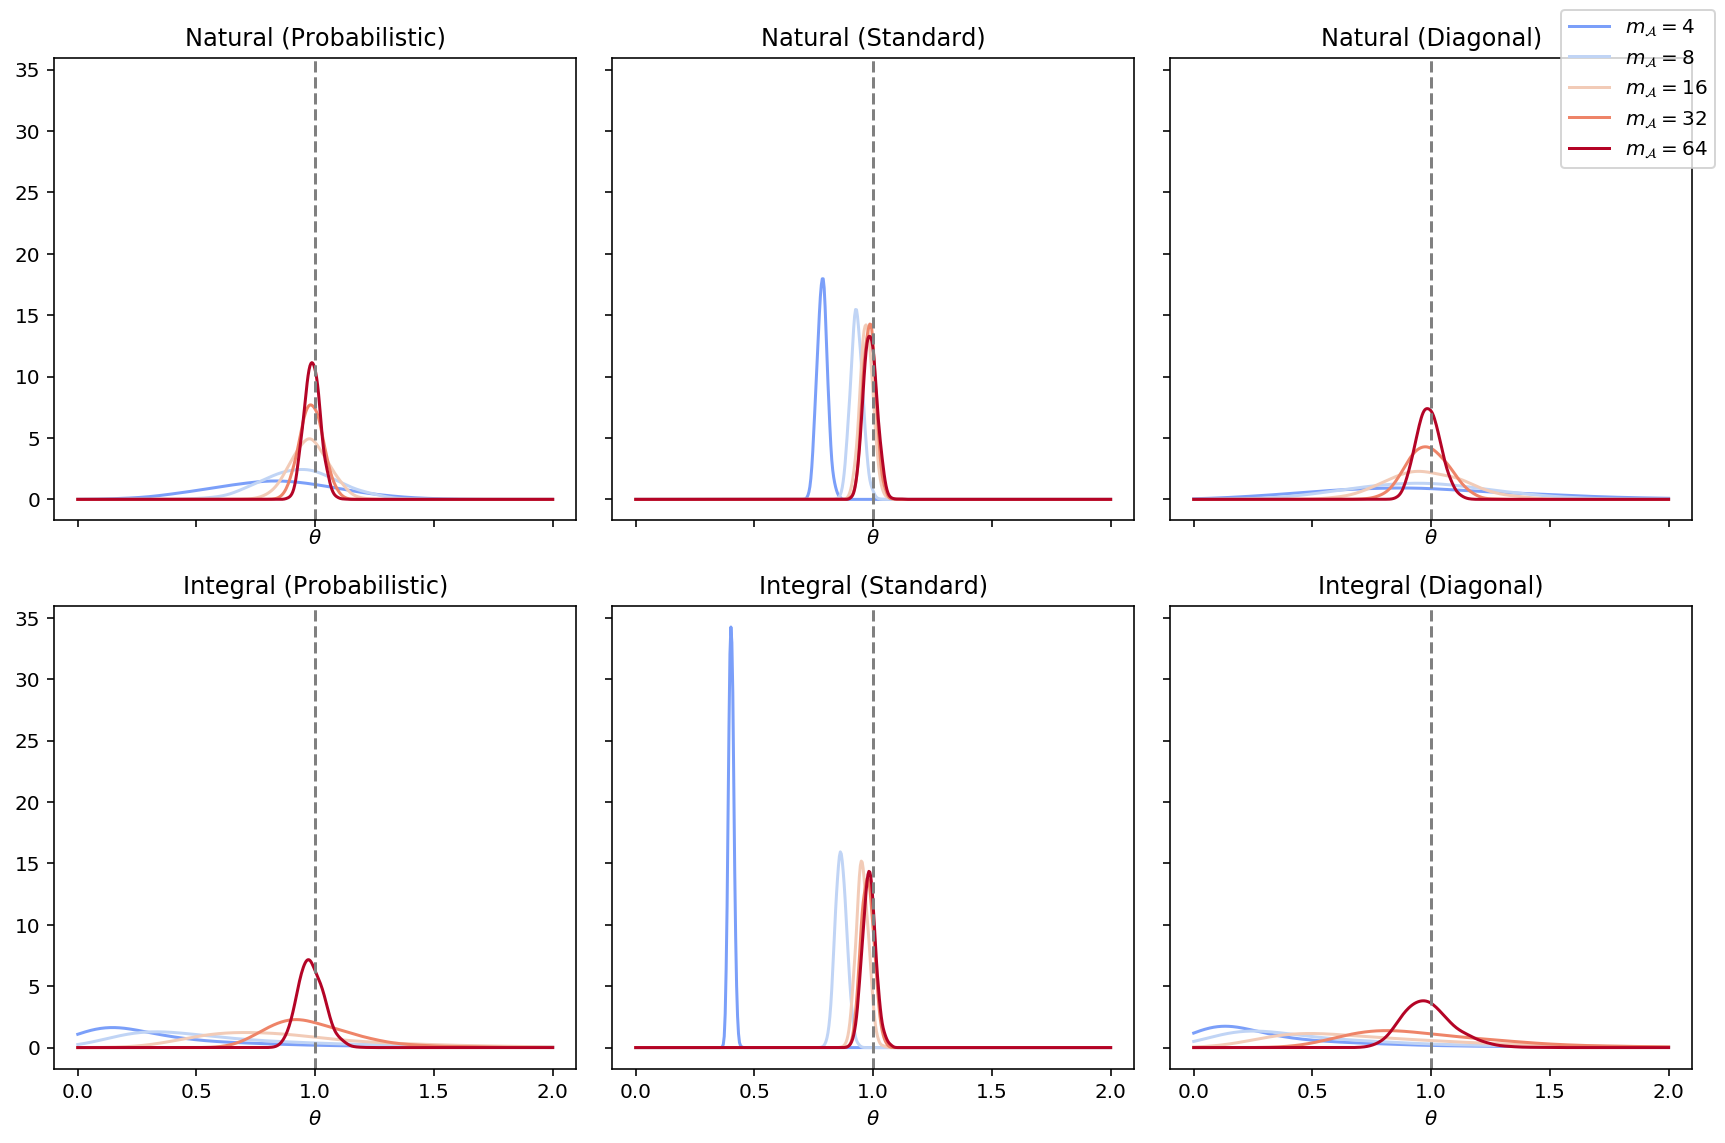

In [58]:
from scipy.stats import gaussian_kde 
from matplotlib import colors
import matplotlib.cm as cmx
cm = plt.get_cmap('coolwarm')
cNorm  = colors.Normalize(vmin=0, vmax=1)
burn = 10000
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True, squeeze=True)
scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=cm)
space = np.linspace(0.0, 2.0, 500)
ix_ax = 0
for dic, label in zip(dictionaries, labels):
    lines = []
    ax = axes.ravel()[ix_ax]
    for ix, n in enumerate(ns):
        samples = dic[n]
        kde = gaussian_kde(np.exp(samples[0][burn:,:]).T, 0.3)
        l, = ax.plot(space, kde(space), label=n, c=scalar_map.to_rgba((ix+1)*1./len(ns)))
        lines.append(l)
    ax.axvline(1.0, linestyle='--', color='gray')
    ax.set_title(label)
    ax.set_xlabel('$\\theta$')
    ix_ax += 1
plt.tight_layout()
plt.figlegend(lines, ['$m_{\\mathcal{A}} = ' + str(n) + '$' for n in ns], 1)
plt.savefig('figures/example_posteriors.pdf', transparent=True, bbox_inches=0)

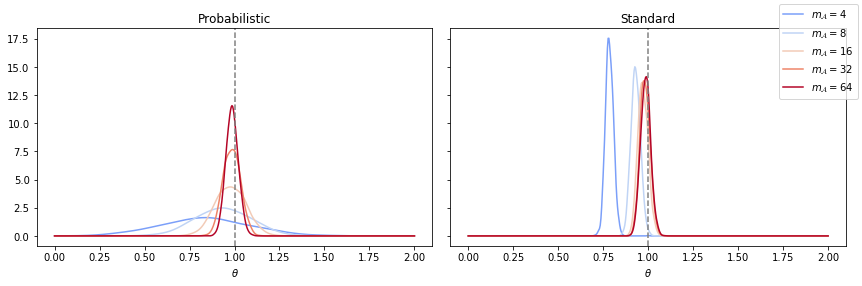

In [47]:
from scipy.stats import gaussian_kde 
from matplotlib import colors
import matplotlib.cm as cmx
cm = plt.get_cmap('coolwarm')
cNorm  = colors.Normalize(vmin=0, vmax=1)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True, squeeze=True)
scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=cm)
space = np.linspace(0.0, 2.0, 500)
ix_ax = 0
labels2 = ['Probabilistic', 'Standard']
for dic, label in zip(dictionaries, labels2):
    lines = []
    ax = axes.ravel()[ix_ax]
    for ix, n in enumerate(ns):
        samples = dic[n]
        kde = gaussian_kde(np.exp(samples[0]).T, 0.3)
        l, = ax.plot(space, kde(space), label=n, c=scalar_map.to_rgba((ix+1)*1./len(ns)))
        lines.append(l)
    ax.axvline(1.0, linestyle='--', color='gray')
    ax.set_title(label)
    ax.set_xlabel('$\\theta$')
    ix_ax += 1
plt.tight_layout()
plt.figlegend(lines, ['$m_{\\mathcal{A}} = ' + str(n) + '$' for n in ns], 1)
plt.savefig('figures/example_posteriors_nat.pdf', transparent=True, bbox_inches=0)

In [ ]:
def dic_to_means_stds(ns, dic):
    means = [np.exp(dic[n]).mean() for n in ns]
    stds = [np.exp(dic[n]).std() for n in ns]
    return np.array(means), np.array(stds)

fig, axes = plt.subplots(2, 2, figsize=(12,8), sharey=True, squeeze=True)
ix = 0
for label, dict in zip(labels, dictionaries):
    ax = axes.ravel()[ix]
    ax.set_title(label)
    means, stds = dic_to_means_stds(ns, dict)
    ax.errorbar(ns, means, stds, marker='o', markerfacecolor='white', markersize=4)
    #plt.fill_between(ns, means+stds, means-stds, alpha = 0.5, linewidth=0, color=ls[0].get_c())
    #plt.legend(loc=2, bbox_to_anchor=(1.05, 1.))
    ax.axhline(1.0, linestyle='--', c='gray')
    ax.set_xlabel('$n$')
    ax.set_ylabel('$\\theta$')
    ix += 1
plt.tight_layout()
plt.savefig('figures/example_inverse_convergence.pdf', transparent=True, bbox_inches=0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True, squeeze=True)
ix = 0
for label, dict in zip(labels2, dictionaries):
    ax = axes.ravel()[ix]
    ax.set_title(label)
    means, stds = dic_to_means_stds(ns, dict)
    ax.errorbar(ns, means, stds, marker='o', markerfacecolor='white', markersize=4)
    #plt.fill_between(ns, means+stds, means-stds, alpha = 0.5, linewidth=0, color=ls[0].get_c())
    #plt.legend(loc=2, bbox_to_anchor=(1.05, 1.))
    ax.axhline(1.0, linestyle='--', c='gray')
    ax.set_xlabel('$n$')
    ax.set_ylabel('$\\theta$')
    ix += 1
plt.tight_layout()
plt.savefig('figures/example_inverse_convergence_nat.pdf', transparent=True, bbox_inches=0)

# Natural Kernel Picture

In [ ]:
def tri_centroid(xs, ys):
    cent_x = np.sum(xs) / 3
    cent_y = np.sum(ys) / 3
    return cent_x, cent_y

In [ ]:
plt.figure(figsize=(6,6))
eps = 0.1
fs = 18
x = 0.6
box_color='blue'
x_prime = 0.8
#plt.plot([0, 0.9], [0.1, 1.0], c='black')
#plt.plot([0.1, 1.0], [0, 0.9], c='black')
plt.fill_between([0, x-eps], [eps, x], [x, x], color='gray')
plt.fill_between([0, x-eps], [x, x], [x_prime, x_prime], color='gray')
plt.fill_between([x-eps, x], [x, x_prime-eps], [x_prime, x_prime], hatch='*', color='gray', linewidth=0)
# outside area
plt.fill_between([eps, x], [0, 0], [0, x-eps], color='gray')
plt.fill_between([0, x], [x_prime, x_prime], [1, 1], color='gray')
plt.fill_between([x, 1], [0, 0], [1, 1], color='gray')
plt.plot([x, x], [0, x_prime], c=box_color)
plt.plot([0, x], [x_prime, x_prime], c=box_color)
plt.plot([0, x], [x+eps, x+eps], c='black', linestyle='--')
plt.plot([eps, x], [0, x-eps], c='black', linestyle='--')
plt.plot([0, x], [eps, x+eps], c='black', linestyle='--')

#plt.annotate('a', (x, x_prime-0.1), xytext=(x+eps,x_prime-eps), arrowprops=dict(facecolor='blue'), fontsize=fs)
plt.annotate('a', (x/2, x_prime+0.01), fontsize=fs, color=box_color, ha='center')
plt.annotate('b', tri_centroid([eps, x, x], [0, 0, x-eps]), fontsize=fs, va='center', ha='center')
plt.annotate('c', tri_centroid([0, x, 0], [eps, x+eps, x+eps]), fontsize=fs, va='center', ha='center')
plt.annotate('d', (x/2, x+eps+(x_prime-x-eps)/2), fontsize=fs, va='center', ha='center')

plt.text(x/2, x/2, 'Target Integral', ha='center', va='center', rotation=45, fontsize=fs)

plt.xticks([eps, x], ['$\\epsilon^{-1}$', '$x$'])
plt.yticks([eps, x+eps, x_prime], ['$\\epsilon^{-1}$', '$x+\\epsilon^{-1}$', "$x'$"])
plt.xlabel('$z$', fontsize=fs)
plt.ylabel("$z'$", fontsize=fs)
plt.xlim(0,1); plt.ylim(0,1);
plt.savefig('integral_sketch.pdf', transparent=True, bbox_inches=0)